<div id="container" style="position:relative;">
<div style="float:centre"><h1> Yelp Review Analysis </h1></div>
<div style="position:relative; float:right"><img style="height:65px" src ="https://drive.google.com/uc?export=view&id=1EnB0x-fdqMp6I5iMoEBBEuxB_s7AmE2k" />
</div>
<div style="position:relative; float:left"><h4> by Lavanya Kwatra (August, 2020) </h4></div>
</div>


### Data Preprocessing

The `sample_yelp_df.csv` file was generated from Notebook 2 after taking a sample of 10,000 rows from the main dataframe. We can now focus on conducting EDA & Text Preprocessing Steps for our model on this smaller dataset. Once we have developed the model, it can be trained and tested on the entire dataset depending upon computational cost and time restraints. However, to show the practical application of this sentiment analysis model, let's begin with the sample yelp reviews dataframe with all attributes related to the review.

In [9]:
# importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [10]:
# reading file into dataframe with pandas
yelp = pd.read_csv('sample_yelp_df.csv', index_col=0)

In [11]:
# to view all columns
pd.set_option('display.max_columns', None)

In [13]:
# exploring null values and columns in the dataframe
yelp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 274420 to 230320
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   review_id              10000 non-null  object 
 1   user_id                10000 non-null  object 
 2   business_id            10000 non-null  object 
 3   review_stars           10000 non-null  int64  
 4   review_useful          10000 non-null  int64  
 5   review_funny           10000 non-null  int64  
 6   review_cool            10000 non-null  int64  
 7   review_text            10000 non-null  object 
 8   review_date            10000 non-null  object 
 9   business_name          10000 non-null  object 
 10  address                9982 non-null   object 
 11  city                   10000 non-null  object 
 12  state                  10000 non-null  object 
 13  postal_code            9998 non-null   object 
 14  latitude               10000 non-null  float64
 

Note: Reference previous notebook, unsure why the timedelta objects have been converted back to objects, so we will need to change this again.

In [20]:
# sum of nulls
yelp.isnull().sum()

review_id                 0
user_id                   0
business_id               0
review_stars              0
review_useful             0
review_funny              0
review_cool               0
review_text               0
review_date               0
business_name             0
address                  18
city                      0
state                     0
postal_code               2
latitude                  0
longitude                 0
business_rating           0
business_review_count     0
business_attributes      14
business_categories       0
user_name                 0
user_review_count         0
user_yelping_since        0
user_useful               0
user_funny                0
user_cool                 0
user_friends              0
user_fans                 0
user_avg_rating           0
review_user_age           0
review_user_lifespan      0
dtype: int64

The missing values in the columns `address` and `business_attributes` pertain to the restaurant address & features, respectively. Since we have all data values for other adddress details, we can make an educated guess about the `address` column to fill the missing values, if & when required. With respect to `business_attributes`, this is an important column that will help study the restaurant features that possibly correlate to a better social perception & rating. However, for our preliminary sentiment classification model, 14 missing values will not heavily impact our analysis and can be ignored.

In [21]:
# lets use the select column function to separate some of these columns from our main review sample dataframe
def select_columns(data_frame, column_names):
    new_frame = data_frame[column_names].copy()
    return new_frame

In [22]:
# creating lists to separate the data columns
loc_col = ['business_id','business_name','city','state','postal_code','address','latitude','longitude']
social_col = ['user_id','user_name','user_friends','user_fans','user_useful','user_funny','user_cool']

In [23]:
# selecting into the data frames below
location = select_columns(yelp, loc_col)
social = select_columns(yelp, social_col)

In [24]:
# dropping the columns that have been moved to the other dataframes, except unique user_id & business_id 
# which is significant to our analysis to group by businesses/users
yelp.drop(columns=loc_col[1:], inplace=True)
yelp.drop(columns=social_col[1:], inplace=True)

In [25]:
# resetting the index after dropping 
yelp.reset_index(drop=True, inplace=True)

## Feature Engineering

1. Let's explore the word count of reviews as this will be a valuable feature to relate to the overall star rating and sentiment scores corresponding to the review text. 

In [26]:
# Creating a column to count the number of spaces in the text data
yelp['review_spaces'] = yelp['review_text'].str.count(' ')

In [27]:
# Count of words in a string = Number of Spaces + 1
yelp['review_word_count'] = (yelp['review_spaces'] + 1)

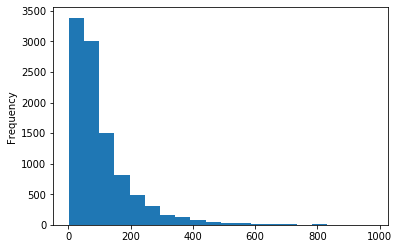

In [35]:
# Plotting the frequency distribution of review_word_count  
plt.figure()
yelp['review_word_count'].plot(kind='hist', bins=20)
plt.show()

Exploring the frequency distribution of the word count of the reviews in our sample, we can see that a majority of the reviews are skewed towards a lower word count. The mean is approximately 100 but the median is lower and the distribution is skewed to the right. This suggests that there are large outliers in our dataset, with some reviews as long as 979 words.

In [36]:
# exploring the range of the review_word_count
yelp['review_word_count'].describe()

count    10000.000000
mean       103.665600
std         99.797224
min          1.000000
25%         40.000000
50%         71.000000
75%        131.000000
max        979.000000
Name: review_word_count, dtype: float64

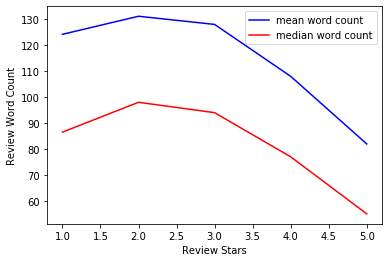



Mean Word Counts:


review_stars
1    124.175911
2    131.140749
3    127.992885
4    107.996237
5     81.945952
Name: review_word_count, dtype: float64



Median Word Counts:


review_stars
1    86.5
2    98.0
3    94.0
4    77.0
5    55.0
Name: review_word_count, dtype: float64

In [50]:
# Exploring the distribution of word count across the review_stars
plt.figure()
plt.plot(yelp.groupby('review_stars')['review_word_count'].mean(), color='blue', label='mean word count')
plt.plot(yelp.groupby('review_stars')['review_word_count'].median(), color='red', label='median word count')
plt.xlabel('Review Stars')
plt.ylabel('Review Word Count')
plt.legend()
plt.show()
print('\n')
print('Mean Word Counts:')
display(yelp.groupby('review_stars')['review_word_count'].mean())
print('\n')
print('Median Word Counts:')
display(yelp.groupby('review_stars')['review_word_count'].median())


- Upon initial glance it seems as though reviews with ratings of 3 stars, usually pertaining to a neutral sentiment, have a higher word count than the reviews with 5 stars or even 1 star. Wordiness tends to signal emotional arousal, and users tend to use more words when they are angry, upset or delighted.

([Kuperman, V., Estes, Z., Brysbaert, M., & Warriner, A. B. (2014). Emotion and language: valence and arousal affect word recognition](https://doi.org/10.1037/a0035669))

- However, when we visualize the mean and median word count for these star ratings, we don't see much of a variance in the shape of the graph, but the values are very different. This suggests a large number of outliers and an imbalanced dataset. Perhaps, this is why the word count of the reviews is not a strong indicator of the sentiment of the user. 


2. Let's now explore the column, `review_user_lifespan` which is the number of days since the user joined Yelp, compared to when the review was written. 

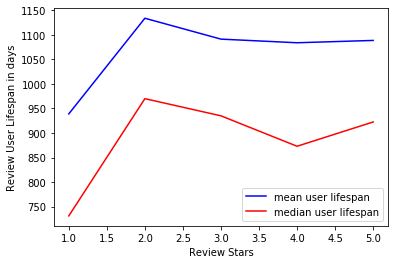



Mean User Lifespan (in days):


review_stars
1     938.966719
2    1133.919410
3    1091.350198
4    1083.953595
5    1088.691905
Name: review_user_lifespan, dtype: float64



Median User Lifespan (in days):


review_stars
1    731.0
2    970.0
3    935.0
4    873.0
5    922.5
Name: review_user_lifespan, dtype: float64

In [54]:
# Exploring the distribution of user lifespan across the review_stars
plt.figure()
plt.plot(yelp.groupby('review_stars')['review_user_lifespan'].mean(), color='blue', label='mean user lifespan')
plt.plot(yelp.groupby('review_stars')['review_user_lifespan'].median(), color='red', label='median user lifespan')
plt.xlabel('Review Stars')
plt.ylabel('Review User Lifespan in days')
plt.legend()
plt.show()
print('\n')
print('Mean User Lifespan (in days):')
display(yelp.groupby('review_stars')['review_user_lifespan'].mean())
print('\n')
print('Median User Lifespan (in days):')
display(yelp.groupby('review_stars')['review_user_lifespan'].median())


- From the above, it seems as though the older & more experienced users are more likely to rate a restaurant 5 stars. However, keeping in mind the imbalance in our target class, we should be cautious about drawing parallels between the age of a user and the sentiment classification.

In [55]:
# dropping the column counting spaces
yelp.drop(columns=['review_spaces'], inplace=True)

In [56]:
# converting date to datetime again 
yelp['review_date'] = yelp['review_date'].apply(pd.to_datetime)

In [57]:
# converting to datetime object 
yelp['user_yelping_since'] = yelp['user_yelping_since'].apply(pd.to_datetime)

In [58]:
yelp['review_date']

0      2017-03-19 21:57:36
1      2011-09-04 03:15:42
2      2018-04-14 11:11:49
3      2017-10-17 19:24:06
4      2017-01-24 20:00:50
               ...        
9995   2019-08-08 21:02:10
9996   2019-06-30 03:49:20
9997   2009-08-18 07:56:58
9998   2017-06-12 19:09:34
9999   2019-11-15 21:26:47
Name: review_date, Length: 10000, dtype: datetime64[ns]

In [59]:
# code to process this column but 
# we have already extracted review_user_lifespan 
# so we can ignore it
# yelp['review_user_age'] = yelp['review_user_age'].str.split(' ')
# yelp.loc[:, 'review_user_age'] = yelp['review_user_age'].map(lambda x: x[0])
# yelp['review_user_age'] = yelp['review_user_age'].astype(int)
# yelp['review_user_age']

In [60]:
yelp['review_date_year'] = yelp['review_date'].dt.year
yelp['review_date_month'] = yelp['review_date'].dt.month
yelp['review_date_day'] = yelp['review_date'].dt.day

In [61]:
yelp.dtypes

review_id                        object
user_id                          object
business_id                      object
review_stars                      int64
review_useful                     int64
review_funny                      int64
review_cool                       int64
review_text                      object
review_date              datetime64[ns]
business_rating                 float64
business_review_count             int64
business_attributes              object
business_categories              object
user_review_count                 int64
user_yelping_since       datetime64[ns]
user_avg_rating                 float64
review_user_age                  object
review_user_lifespan              int64
review_word_count                 int64
review_date_year                  int64
review_date_month                 int64
review_date_day                   int64
dtype: object

In [62]:
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   review_id              10000 non-null  object        
 1   user_id                10000 non-null  object        
 2   business_id            10000 non-null  object        
 3   review_stars           10000 non-null  int64         
 4   review_useful          10000 non-null  int64         
 5   review_funny           10000 non-null  int64         
 6   review_cool            10000 non-null  int64         
 7   review_text            10000 non-null  object        
 8   review_date            10000 non-null  datetime64[ns]
 9   business_rating        10000 non-null  float64       
 10  business_review_count  10000 non-null  int64         
 11  business_attributes    9986 non-null   object        
 12  business_categories    10000 non-null  object        
 13  us

-----------------------------------------------

incomplete


---------------------------------------

# EDA 

1. The first set of features to explore in relation to the stars are the user generated votes on reviews. `review_useful`, `review_funny` and `review_cool` are the three review specific attributes. The first column to compare the distribution to is `review_stars` to see the relationship of user votes to the star rating of the review.

COLUMN: review_useful
n nulls: 0


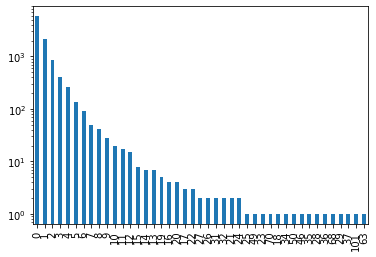

0      5845
1      2155
2       860
3       410
4       261
5       136
6        92
7        50
8        42
9        28
10       20
11       17
12       15
15        8
14        7
13        7
19        5
16        4
20        4
17        3
22        3
27        2
26        2
31        2
32        2
21        2
24        2
25        1
49        1
23        1
70        1
18        1
34        1
50        1
46        1
35        1
28        1
36        1
68        1
29        1
37        1
101       1
63        1
Name: review_useful, dtype: int64

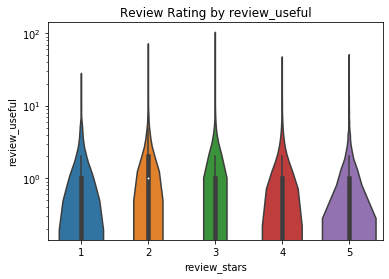



COLUMN: review_funny
n nulls: 0


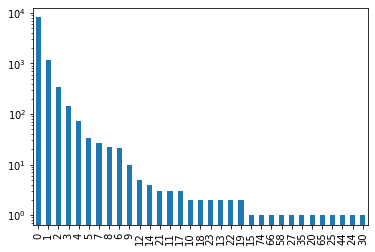

0     8109
1     1173
2      345
3      145
4       73
5       33
7       27
8       22
6       21
9       10
12       5
14       4
21       3
11       3
17       3
10       2
18       2
23       2
13       2
22       2
19       2
15       1
74       1
66       1
58       1
27       1
35       1
20       1
65       1
25       1
44       1
24       1
30       1
Name: review_funny, dtype: int64

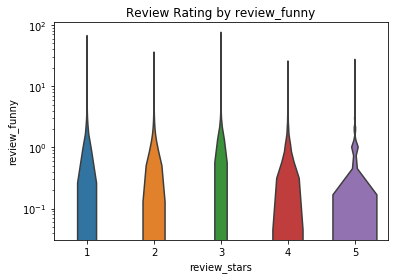



COLUMN: review_cool
n nulls: 0


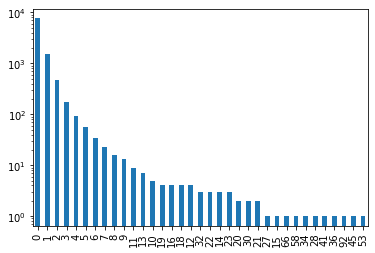

0     7571
1     1492
2      466
3      172
4       92
5       55
6       34
7       23
8       16
9       13
11       9
13       7
10       5
19       4
16       4
18       4
12       4
32       3
22       3
14       3
23       3
20       2
30       2
21       2
27       1
15       1
66       1
58       1
34       1
28       1
41       1
36       1
92       1
45       1
53       1
Name: review_cool, dtype: int64

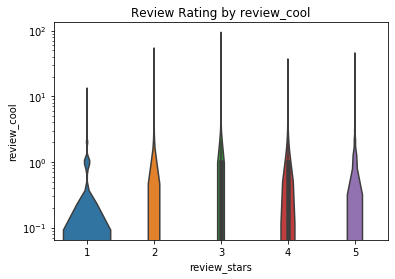

In [69]:
review_votes = ['review_useful','review_funny','review_cool']

for col in review_votes:
    
        df = yelp.copy()
        
        print('COLUMN:', col)
        print('n nulls:', df[col].isna().sum())
    
        # Viz the value counts
        df[col].value_counts().plot(kind='bar')
        plt.yscale('log')
        plt.show()
        
        display(df[col].value_counts())
    
        print('\n')
        
        sns.violinplot(y=col, x='review_stars', data=df)
        plt.title(f'Review Rating by {col}')
        plt.yscale('log')
        plt.show()
    
        print('\n')

COLUMN: review_useful
n nulls: 0


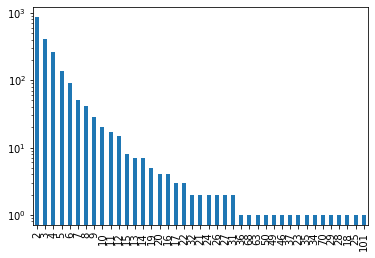

2      860
3      410
4      261
5      136
6       92
7       50
8       42
9       28
10      20
11      17
12      15
15       8
13       7
14       7
19       5
20       4
16       4
17       3
22       3
32       2
21       2
24       2
26       2
27       2
31       2
36       1
68       1
63       1
50       1
49       1
46       1
37       1
23       1
35       1
34       1
70       1
29       1
28       1
18       1
25       1
101      1
Name: review_useful, dtype: int64

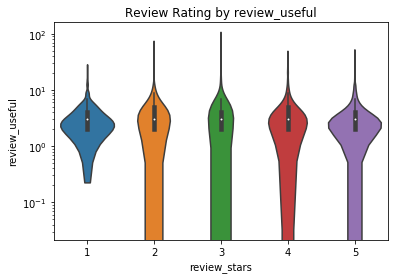



COLUMN: review_funny
n nulls: 0


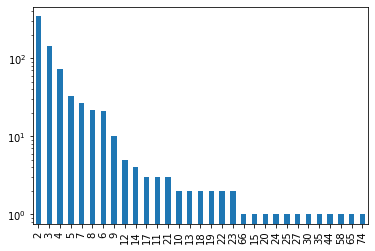

2     345
3     145
4      73
5      33
7      27
8      22
6      21
9      10
12      5
14      4
17      3
11      3
21      3
10      2
13      2
18      2
19      2
22      2
23      2
66      1
15      1
20      1
24      1
25      1
27      1
30      1
35      1
44      1
58      1
65      1
74      1
Name: review_funny, dtype: int64

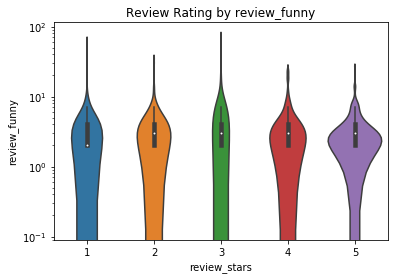



COLUMN: review_cool
n nulls: 0


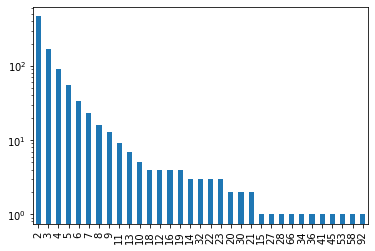

2     466
3     172
4      92
5      55
6      34
7      23
8      16
9      13
11      9
13      7
10      5
18      4
12      4
16      4
19      4
14      3
32      3
22      3
23      3
20      2
30      2
21      2
15      1
27      1
28      1
66      1
34      1
36      1
41      1
45      1
53      1
58      1
92      1
Name: review_cool, dtype: int64

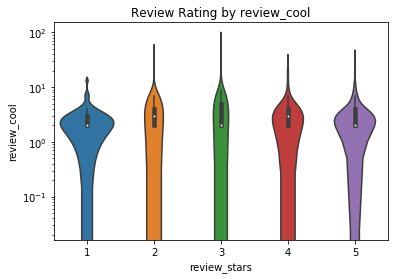

In [70]:
              
review_votes = ['review_useful','review_funny','review_cool']

for col in review_votes:
    
    df = yelp.loc[((yelp[col]!=0) & (yelp[col]!=1))]
    
    print('COLUMN:', col)
    print('n nulls:', df[col].isna().sum())
    
    # Viz the value counts
    df[col].value_counts().plot(kind='bar')
    plt.yscale('log')
    plt.show()
    
    display(df[col].value_counts())
    
    print('\n')
        
    sns.violinplot(y=col, x='review_stars', data=df)
    plt.title(f'Review Rating by {col}')
    plt.yscale('log')
    plt.show()
    
    print('\n')

In [71]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [77]:
review_votes = ['review_useful','review_funny','review_cool']

for col in review_votes:
        
    df[[col]] = scaler.fit_transform(df[[col]])   

/Users/lavanyakwatra/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/lavanyakwatra/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/lavanyakwatra/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

COLUMN: review_useful
n nulls: 0


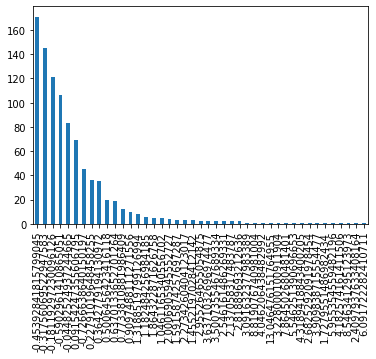

-0.453928     171
-0.317561     145
-0.181193     121
-0.590296     106
-0.044825      83
 0.091542      69
-0.726664      45
 0.227910      36
 0.364278      35
 0.500646      20
 0.637013      19
 0.773381      12
 0.909749      10
 1.318852       8
 1.182484       6
 1.864323       5
 1.046117       5
 2.000691       4
 1.591587       3
 2.273426       3
 1.455220       3
 2.955265       2
 3.637103       2
 3.500736       2
 2.546161       2
 2.137058       2
 2.818897       2
 3.091632       1
 8.819077       1
 4.046206       1
 13.046476      1
 3.228000       1
 7.864503       1
 5.546251       1
 4.318942       1
 2.682529       1
 3.909839       1
 1.727955       1
 5.955355       1
 4.182574       1
 8.546341       1
 2.409794       1
 6.091722       1
Name: review_useful, dtype: int64

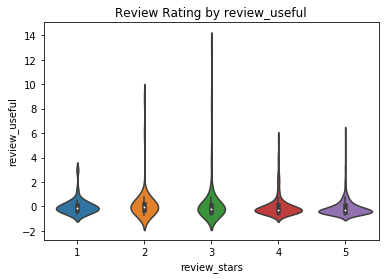



COLUMN: review_funny
n nulls: 0


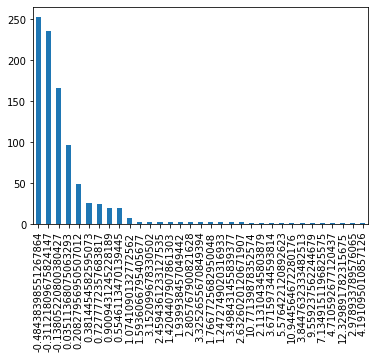

-0.484384     253
-0.311218     236
-0.138052     166
 0.035114      96
 0.208280      49
 0.381445      26
 0.727777      25
 0.900943      20
 0.554611      19
 1.074109       8
 1.593607       3
 3.152100       3
 2.459436       3
 1.420441       3
 1.939938       3
 2.805768       2
 3.325266       2
 1.766773       2
 1.247275       2
 3.498431       2
 2.632602       2
 10.771399      1
 2.113104       1
 3.671597       1
 5.576422       1
 10.944565      1
 3.844763       1
 9.559238       1
 7.134915       1
 4.710593       1
 12.329892      1
 2.978934       1
 4.191095       1
Name: review_funny, dtype: int64

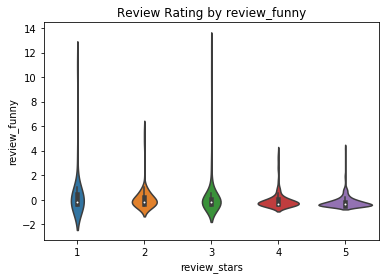



COLUMN: review_cool
n nulls: 0


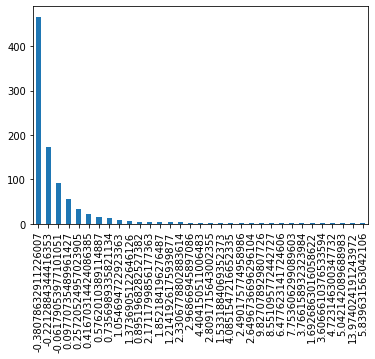

-0.380786     466
-0.221288     172
-0.061791      92
 0.097707      55
 0.257205      34
 0.416703      23
 0.576201      16
 0.735699      13
 1.054695       9
 1.373691       7
 0.895197       5
 2.171180       4
 1.852184       4
 1.214193       4
 2.330678       4
 2.968669       3
 4.404151       3
 2.809172       3
 1.533188       3
 4.085155       2
 2.490176       2
 2.649674       2
 9.827079       1
 8.551096       1
 6.477623       1
 7.753606       1
 3.766159       1
 1.692686       1
 3.606661       1
 4.723146       1
 5.042142       1
 13.974024      1
 5.839632       1
Name: review_cool, dtype: int64

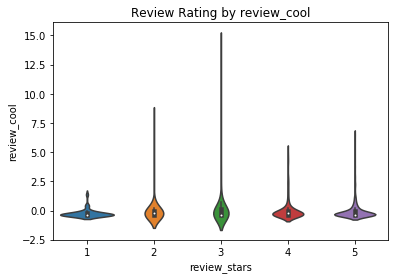

In [79]:
review_votes = ['review_useful','review_funny','review_cool']

for col in review_votes:
    
        print('COLUMN:', col)
        print('n nulls:', df[col].isna().sum())
    
        # Viz the value counts
        df[col].value_counts().plot(kind='bar')
        
        plt.show()
        
        display(df[col].value_counts())
    
        print('\n')
        
        sns.violinplot(y=col, x='review_stars', data=df)
        plt.title(f'Review Rating by {col}')
        
        plt.show()
    
        print('\n')


-------







COLUMN: review_stars


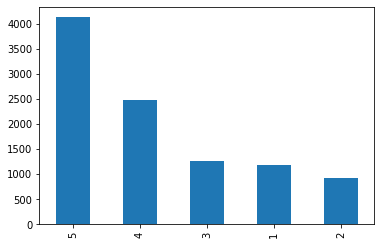

5    4130
4    2491
3    1265
1    1194
2     920
Name: review_stars, dtype: int64



COLUMN: review_date_year


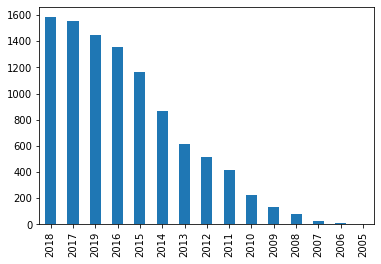

2018    1583
2017    1556
2019    1448
2016    1355
2015    1165
2014     867
2013     618
2012     512
2011     418
2010     228
2009     133
2008      77
2007      28
2006      10
2005       2
Name: review_date_year, dtype: int64



COLUMN: review_date_month


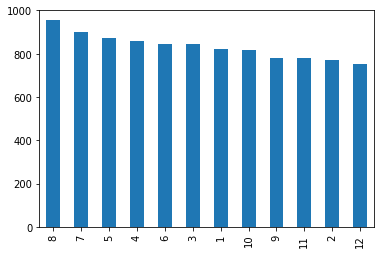

8     956
7     901
5     871
4     858
6     846
3     844
1     821
10    816
9     782
11    780
2     773
12    752
Name: review_date_month, dtype: int64



COLUMN: review_date_day


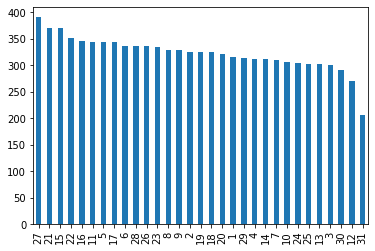

27    391
21    371
15    370
22    352
16    346
11    344
5     344
17    343
6     337
28    336
26    336
23    334
8     328
9     328
2     324
19    324
18    324
20    322
1     315
29    314
4     312
14    312
7     310
10    306
24    304
25    303
13    302
3     301
30    290
12    271
31    206
Name: review_date_day, dtype: int64

In [81]:
usage_trend_analysis = ['review_stars','review_date_year','review_date_month','review_date_day']
for col in usage_trend_analysis:
    
    print('COLUMN:', col)
    
    # Viz the value counts
    yelp[col].value_counts().plot(kind='bar')
    plt.show()
    
    display(yelp[col].value_counts())
    
    
    print('\n')

In [63]:
review_3stars = pd.DataFrame((yelp[['review_id','review_text','review_stars']].where(yelp['review_stars']==3)))

In [64]:
review_3stars.dropna(inplace=True)

In [65]:
review_3stars

review_id  \
4     qshh1SX-TyiG4IDReNk8lg   
9     4rknHQ-eaoZ1L1GA9YuoHA   
10    goxvgfiEmWlB4qlRFI-f0g   
21    leEGWp7I3KHa0bnDqETRgg   
22    iym5o_ql90eAHNv28z8Rsg   
...                      ...   
9973  i86Ww4f_erQCFADJweFxlg   
9981  YZiRhB_fLJ9FpdgFgYHouQ   
9985  PWr1e5xsaFTPWoxxxdSnvA   
9989  q4AIBNlIGYG7SGeKFgwbEQ   
9990  ijlpIjLiXrz5UjckHfQ8ZA   

                                            review_text  review_stars  
4     we came for lunch with a group of  no wait for...           3.0  
9     this buffet has gone down hill significantly o...           3.0  
10    empty stomach required fried chicken with jam ...           3.0  
21    theres better jerk out there\n\nthe jerk chick...           3.0  
22    i think the food at chipotle is pretty good i ...           3.0  
...                                                 ...           ...  
9973  i was so excited and looking forward to dine a...           3.0  
9981  nothing special reallyhave been once and altho...           3.0  
9985  decent food but super strange seating arrangem...           3.0  
9989  dont bother too many other good restaurants in...           3.0  
9990  kind of disappointed went to lunch today with ...           3.0  

[1265 rows x 3 columns]

- We will count 3 stars as a negative sentiment bc


-------

## Text Processing



sentiment analysis to understand mood of the text - 

step 1 -

using rating as the sentiment to analyze
view the distribution of ratings
simplify to positive and negative by discarding all reviews with rating of 3, and setting 1,2 as 0 or negative and 4,5 as 1 or positive 

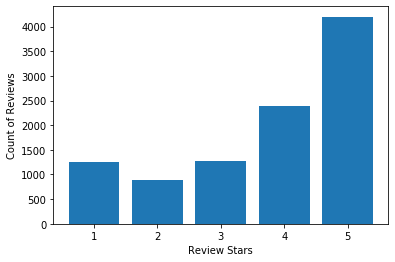

In [66]:
values, counts = np.unique(yelp['review_stars'], return_counts=True)

plt.figure()
plt.bar(values, counts)
plt.xlabel('Review Stars')
plt.ylabel('Count of Reviews')
plt.show()

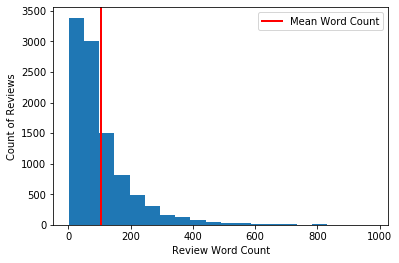

In [67]:
plt.figure()
plt.hist(yelp['review_word_count'], bins=20)
plt.xlabel('Review Word Count')
plt.ylabel('Count of Reviews')
plt.axvline(x=yelp['review_word_count'].mean(),
            linewidth = 2,
            linestyle = 'solid',
            color = 'red', label = 'Mean Word Count')
plt.legend()
plt.show()

In [68]:
nlp = yelp.copy()

In [69]:
nlp.isna().sum()

review_id                 0
user_id                   0
business_id               0
review_stars              0
review_useful             0
review_funny              0
review_cool               0
review_text               0
review_date               0
business_rating           0
business_review_count     0
business_attributes      14
business_categories       0
user_review_count         0
user_yelping_since        0
user_avg_rating           0
review_user_age           0
review_user_lifespan      0
review_word_count         0
review_date_year          0
review_date_month         0
review_date_day           0
dtype: int64

In [71]:
conversion_dict = {1:0, 2:0, 3:0, 4:1, 5:1}
nlp['review_stars'] = yelp['review_stars'].map(conversion_dict)
nlp.head()

review_id                 user_id             business_id  \
0  Tw6wFw6pEl0Tl7Y7Hemn3Q  s39od3C87anwrI-BDLm1Lg  BjrKNWhtQkedHw8hP_0Bjg   
1  jsRiZf8Yh-9GggItbHuNBQ  5lq2BXeV8wZvtTRixgnegQ  j9cVHTAIkliYQp4XoVcsnQ   
2  gPODPd8YEuyLMpjE8FwDCw  E7yc9-Z7ewSgtogwie4z6w  prmB45ETnpuTwc-p_ztAVA   
3  cd5kSWII0IWSMVtOd7oMVA  zW7X5YkYrIrRA0EDjNiVUg  QcV8KIPKbGRnWQPql55bKQ   
4  qshh1SX-TyiG4IDReNk8lg  YU9ya3EYQWNhffBwTNyfVw  pjys1m9gkIylfnidNz9a-w   

   review_stars  review_useful  review_funny  review_cool  \
0             1              0             0            0   
1             0              0             0            0   
2             1              0             0            0   
3             0              0             0            0   
4             0              1             0            1   

                                         review_text         review_date  \
0  visited umami today on recommendation of other... 2017-03-19 21:57:36   
1  the place itself is a nice change of pace i li... 2011-09-04 03:15:42   
2  when i got there was quickly greeted and confi... 2018-04-14 11:11:49   
3  bad experience took over an hour for a small p... 2017-10-17 19:24:06   
4  we came for lunch with a group of  no wait for... 2017-01-24 20:00:50   

   business_rating  business_review_count  \
0              4.5                    720   
1              3.5                    275   
2              4.5                     72   
3              2.5                    103   
4              4.0                    141   

                                 business_attributes  \
0  {'RestaurantsAttire': "'casual'", 'Restaurants...   
1  {'BikeParking': 'True', 'WiFi': "u'free'", 'Ca...   
2  {'Ambience': "{'touristy': False, 'hipster': F...   
3  {'BikeParking': 'True', 'BusinessParking': "{'...   
4  {'BikeParking': 'True', 'RestaurantsAttire': "...   

                                 business_categories  user_review_count  \
0  Sushi Bars, Japanese, Restaurants, Buffets, De...                  3   
1  Irish, Pubs, Sports Bars, Restaurants, Irish P...                 19   
2       Wraps, Food, Bagels, Sandwiches, Restaurants                  8   
3                        Restaurants, Italian, Pizza                  3   
4                 Restaurants, Asian Fusion, Noodles                  7   

   user_yelping_since  user_avg_rating               review_user_age  \
0 2015-11-21 03:26:14             4.00   484 days 18:31:22.000000000   
1 2009-10-05 16:47:12             3.40   698 days 10:28:30.000000000   
2 2014-12-12 22:42:31             3.50  1218 days 12:29:18.000000000   
3 2016-08-16 20:04:53             3.67   426 days 23:19:13.000000000   
4 2017-01-24 19:39:23             3.86     0 days 00:21:27.000000000   

   review_user_lifespan  review_word_count  review_date_year  \
0                   484                 64              2017   
1                   698                106              2011   
2                  1218                112              2018   
3                   426                 17              2017   
4                     0                 66              2017   

   review_date_month  review_date_day  
0                  3               19  
1                  9                4  
2                  4               14  
3                 10               17  
4                  1               24

In [94]:
import nltk
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [152]:
# create a tokenizer to split the sentences into words 
# lemmatize words
stop_words = stopwords.words('english')
lem = WordNetLemmatizer()

def my_tokenizer(sentence):

    listofwords = sentence.strip().split()          
    listof_words = []  
    
    for word in listofwords:
        if not word in stop_words and word!=(' ') and word!='int':
            lemm_word = WordNetLemmatizer().lemmatize(word)
            listof_words.append(word)
    return(listof_words)

In [185]:
from sklearn.model_selection import train_test_split

X = nlp['review_text']
y = nlp['review_stars']

#split the data into remainder and test
X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size = 0.2,
                     random_state=1)

# split remainder into train and validation 
X_train, X_validation, y_train, y_validation = train_test_split(X_remainder, y_remainder, test_size = 0.3,
                     random_state=1)

In [186]:
tfidf = TfidfVectorizer(min_df=5, tokenizer = my_tokenizer, 
                         ngram_range = (1,3))

In [187]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf.fit(X_train)
X_train = tfidf.transform(X_train)
X_test = tfidf.transform(X_test)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [172]:
X_train

<7000x13019 sparse matrix of type '<class 'numpy.float64'>'
	with 375502 stored elements in Compressed Sparse Row format>

In [181]:
nlp_words = pd.DataFrame(columns=tfidf.get_feature_names(), data=X_train.toarray())
nlp_words

abandoned  ability  able  able enjoy  able find  able finish  able get  \
0           0.0      0.0   0.0         0.0        0.0          0.0       0.0   
1           0.0      0.0   0.0         0.0        0.0          0.0       0.0   
2           0.0      0.0   0.0         0.0        0.0          0.0       0.0   
3           0.0      0.0   0.0         0.0        0.0          0.0       0.0   
4           0.0      0.0   0.0         0.0        0.0          0.0       0.0   
...         ...      ...   ...         ...        ...          ...       ...   
6995        0.0      0.0   0.0         0.0        0.0          0.0       0.0   
6996        0.0      0.0   0.0         0.0        0.0          0.0       0.0   
6997        0.0      0.0   0.0         0.0        0.0          0.0       0.0   
6998        0.0      0.0   0.0         0.0        0.0          0.0       0.0   
6999        0.0      0.0   0.0         0.0        0.0          0.0       0.0   

      able go  able make  able order  able sit  able take  able try  \
0         0.0        0.0         0.0       0.0        0.0       0.0   
1         0.0        0.0         0.0       0.0        0.0       0.0   
2         0.0        0.0         0.0       0.0        0.0       0.0   
3         0.0        0.0         0.0       0.0        0.0       0.0   
4         0.0        0.0         0.0       0.0        0.0       0.0   
...       ...        ...         ...       ...        ...       ...   
6995      0.0        0.0         0.0       0.0        0.0       0.0   
6996      0.0        0.0         0.0       0.0        0.0       0.0   
6997      0.0        0.0         0.0       0.0        0.0       0.0   
6998      0.0        0.0         0.0       0.0        0.0       0.0   
6999      0.0        0.0         0.0       0.0        0.0       0.0   

      able watch  absolute  absolute best  absolute favorite  absolutely  \
0            0.0       0.0            0.0                0.0         0.0   
1            0.0       0.0            0.0                0.0         0.0   
2            0.0       0.0            0.0                0.0         0.0   
3            0.0       0.0            0.0                0.0         0.0   
4            0.0       0.0            0.0                0.0         0.0   
...          ...       ...            ...                ...         ...   
6995         0.0       0.0            0.0                0.0         0.0   
6996         0.0       0.0            0.0                0.0         0.0   
6997         0.0       0.0            0.0                0.0         0.0   
6998         0.0       0.0            0.0                0.0         0.0   
6999         0.0       0.0            0.0                0.0         0.0   

      absolutely amazing  absolutely best  absolutely delicious  \
0                    0.0              0.0                   0.0   
1                    0.0              0.0                   0.0   
2                    0.0              0.0                   0.0   
3                    0.0              0.0                   0.0   
4                    0.0              0.0                   0.0   
...                  ...              ...                   ...   
6995                 0.0              0.0                   0.0   
6996                 0.0              0.0                   0.0   
6997                 0.0              0.0                   0.0   
6998                 0.0              0.0                   0.0   
6999                 0.0              0.0                   0.0   

      absolutely disgusting  absolutely fantastic  absolutely horrible  \
0                       0.0                   0.0                  0.0   
1                       0.0                   0.0                  0.0   
2                       0.0                   0.0                  0.0   
3                       0.0                   0.0                  0.0   
4                       0.0                   0.0                  0.0   
...                     ...   

In [182]:
word_weights = np.array(np.sum(X_train, axis=0)).reshape((-1))
words = np.array(tfidf.get_feature_names())
words_df = pd.DataFrame({'word':words, 'weight':word_weights})
words_df.sort_values(by='weight',ascending=False).head(10)

word      weight
3944      food  214.990707
4761      good  187.704425
5053     great  177.831738
8421     place  176.643509
10009  service  147.991400
6366      like  113.230820
660       back  108.123263
7738       one  107.666456
11503     time  106.595915
4500       get  103.329187

In [183]:
# Logistic Regression 
from sklearn.linear_model import LogisticRegression 

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

logreg.score(X_train, y_train)

0.9271428571428572

In [184]:
# test score
logreg.score(X_test, y_test)

0.8836666666666667